# Benchmark
#### Author: JP Melo

### Imports

In [6]:
from derpinns.nn import *
from derpinns.utils import *
from derpinns.trainer import *
import time
import torch
import kfac
import json
import os

## Parameters

In [7]:
# Fix seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Global parameters
n_assets = [1,3,5,7,10]
sampler = "pseudo"                                         
nn_shapes = ["10x6"]                
device = torch.device("cpu")   
dtype = torch.float32

In [8]:
def handle_serialization(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, list):
        return [handle_serialization(item) for item in obj]
    elif isinstance(obj, dict):
        return {k: handle_serialization(v) for k, v in obj.items()}
    elif isinstance(obj, float):
        return float(obj)
    elif isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.float64):
        return float(obj)
    else:
        raise TypeError(f"Type {type(obj)} not serializable")

## Training

We use a multi-stage training process, where the first stage is done with ADAM and the second stage with SSBroyden as this methods achieve the best perfomance.

In [9]:
# load json if it exists, else create it
try:
    with open("bench.json", "r") as f:
        bench = json.load(f)
except FileNotFoundError:
    bench = {}
    with open("bench.json", "w") as f:
        json.dump(bench, f)

In [10]:
for nn_shape in nn_shapes:
    for assets in n_assets:
        print(f"Training {nn_shape} with {assets} assets")
        # check if the combination already exists, if so skip
        if f"{nn_shape}_{assets}" in bench:
            print(f"Already trained {nn_shape} with {assets} assets")
            continue

        params = OptionParameters(
            n_assets=assets,
            tau=1.0,
            sigma=np.array([0.2] * assets),
            rho=np.eye(assets) + 0.25 * (np.ones((assets, assets)) - np.eye(assets)),
            r=0.05,
            strike=100,
            payoff=payoff
        )

        # Build the net to be used
        model = build_nn(
            nn_shape,
            input_dim=assets+1)
        
        model.train()

        # Set the training parameters
        batch_size = 200
        total_iter = 10
        boundary_samples = 20_000
        interior_samples = boundary_samples*assets*2
        initial_samples = boundary_samples*assets*2

        # Create dataset to traing over
        dataset = SampledDataset(
            params, interior_samples, initial_samples, boundary_samples, sampler, dtype, device, seed=0)

        # Set optimizer and training function
        # 1e-2 is big enought to reach a reasonable min in few steps
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
        preconditioner = kfac.preconditioner.KFACPreconditioner(model)

        # # Set the training function
        closure = DimlessBS()\
            .with_dataset(dataset, loader_opts={'batch_size': batch_size, "shuffle": True, "pin_memory": True})\
            .with_model(model)\
            .with_device(device)\
            .with_dtype(dtype)

        trainer = PINNTrainer()\
            .with_optimizer(optimizer)\
            .with_device(device)\
            .with_dtype(dtype)\
            .with_training_step(closure)\
            .with_preconditioner(preconditioner)\
            .with_epochs(total_iter)\
        
        start = time.time()
        trainer.train()
        adam_time = time.time() - start

        boundary_samples = 100
        interior_samples = boundary_samples*assets*2
        initial_samples = boundary_samples*assets*2

        # We create new samples
        dataset = SampledDataset(
            params, interior_samples, initial_samples, boundary_samples, sampler, dtype, device, seed=0)

        optimizer = LBFGS(
            model.parameters(),
            max_iter=5_000,
            line_search_fn="strong_wolfe",
        )
        batch_size = len(dataset) # we use all samples

        closure = closure.with_dataset(
            dataset, loader_opts={'batch_size': batch_size, "shuffle": False, "pin_memory": True})

        trainer = trainer.with_optimizer(optimizer).with_training_step(closure)

        start = time.time()
        trainer.train()
        ssbroyden_time = time.time() - start

        state = closure.get_state()
        # We save the model
        torch.save(model.state_dict(), f"model_{nn_shape}_{assets}.pt")

        eval = compare_with_mc(model, params, n_prices=200,
                          n_simulations=10_000, dtype=dtype, device=device, seed=42)
        print("L2 Error (%): ", eval['l2_rel_error']*100)
        
        bench[f"{nn_shape}_{assets}"] = {
            "adam_time": adam_time,
            "ssbroyden_time": ssbroyden_time,
            "steps": len(state['interior_loss']),
            "state": state,
            "evaluation": eval
        }

        with open("bench.json", "w") as f:
            json.dump(bench, f, default=handle_serialization, indent=4)

Training 10x6 with 1 assets


Adam training:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x2 and 3x10)

## Analysis

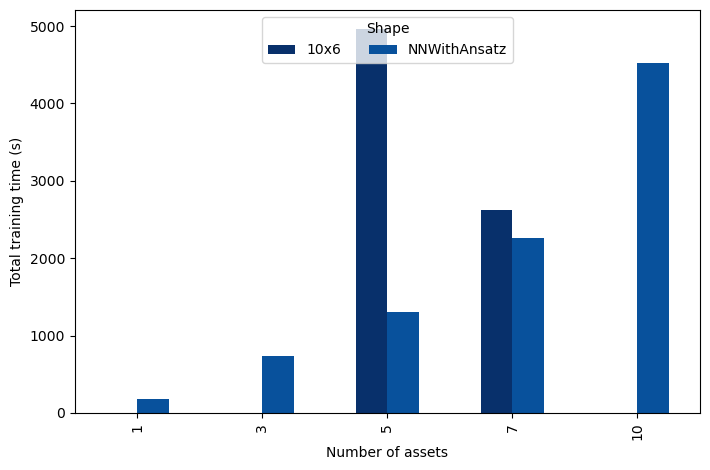

/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_33900/2518484479.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
# Plotting the results
fig = plot_evaluation_times(
    bench,
    backend="matplotlib",
    fig_size=(720, 480),
    scale_nn=1.0,
    use_log=False
)

fig.show()

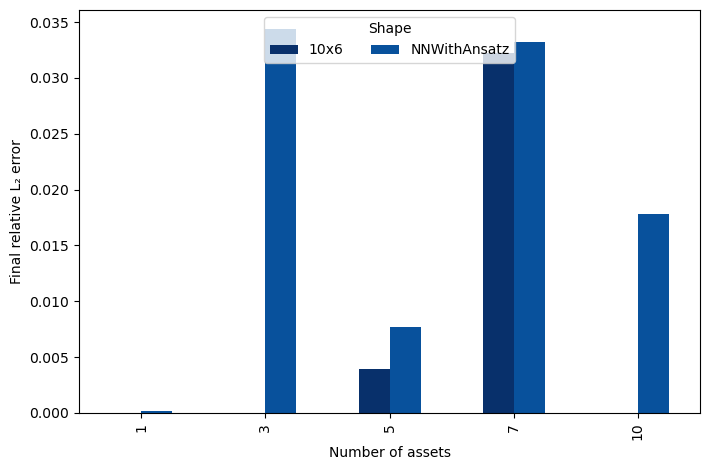

/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_33900/1680574077.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
fig = plot_l2_error(
    bench,
    backend="matplotlib",
    fig_size=(720, 480),
    scale_nn=1.0,
    use_log=False,
    yscale="linear",
)
fig.show()